https://stackoverflow.com/questions/50060241/how-to-use-glove-word-embeddings-file-on-google-colaboratory

In [ ]:
import pandas as pd
import numpy as np
data_directory = "drive/My Drive/MTP/data/"

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!wget http://nlp.stanford.edu/data/glove.twitter.27B.zip

--2020-09-22 15:58:52--  http://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.twitter.27B.zip [following]
--2020-09-22 15:58:52--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2020-09-22 15:58:53--  http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [appli

In [ ]:
!unzip glove.twitter.27B.zip

Archive:  glove.twitter.27B.zip
  inflating: glove.twitter.27B.25d.txt  
  inflating: glove.twitter.27B.50d.txt  
  inflating: glove.twitter.27B.100d.txt  
  inflating: glove.twitter.27B.200d.txt  


In [ ]:
!ls
!pwd

adc.json	   glove.6B.50d.txt	       glove.twitter.27B.50d.txt
drive		   glove.6B.zip		       glove.twitter.27B.zip
glove.6B.100d.txt  glove.twitter.27B.100d.txt  sample_data
glove.6B.200d.txt  glove.twitter.27B.200d.txt
glove.6B.300d.txt  glove.twitter.27B.25d.txt
/content


In [ ]:
print('Indexing word vectors.')

embeddings_index = {}
f = open('glove.twitter.27B.200d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 1193514 word vectors.


In [ ]:
import pickle
pickle.dump({'embeddings_index' : embeddings_index } , open(data_directory + 'GloVe_Twitter_embeddings', 'wb'))

In [ ]:
import logging
import numpy as np
import sys
from time import time
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics

In [ ]:
preprocessed_train_tsv = data_directory + "preprocessed_train.tsv"  #remove ‘content/’ from path then use 
train_data = pd.read_csv(preprocessed_train_tsv, sep='\t')
#X_valid = vectorizer.fit_transform(valid_data['Text'].to_numpy())
X_train = []
for index, row in train_data.iterrows():
  X_train.append(row['Text'])
X_train = np.array(X_train)
y_train = train_data['Label'].to_numpy()

In [ ]:
validation_tsv = data_directory + "preprocessed_valid.tsv"  #remove ‘content/’ from path then use 
valid_data = pd.read_csv(validation_tsv, sep='\t')
#X_valid = vectorizer.fit_transform(valid_data['Text'].to_numpy())
X_valid = []
for index, row in valid_data.iterrows():
  X_valid.append(row['Text'])
X_valid = np.array(X_valid)
y_valid = valid_data['Label'].to_numpy()

In [ ]:
data_train = X_train

data_test = X_valid

print('data loaded')

target_names = ['0', '1']

def size_mb(docs):
    return sum(len(s.encode('utf-8')) for s in docs) / 1e6


data_train_size_mb = size_mb(data_train)
data_test_size_mb = size_mb(data_test)

print("%d documents - %0.3fMB (training set)" % (
    len(data_train), data_train_size_mb))
print("%d documents - %0.3fMB (test set)" % (
    len(data_test), data_test_size_mb))
print("%d categories" % len(target_names))
print()

# split a training set and a test set
y_train, y_test = y_train, y_valid

data loaded
6936 documents - 0.979MB (training set)
1000 documents - 0.140MB (test set)
2 categories



In [ ]:
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
def avgEmbed(x):
  #print(x)
  count = 0
  allvecs = []

  for i in sent_tokenize(x): 
    temp = [] 
      
    # tokenize the sentence into words 
    for j in word_tokenize(i): 
        if j in embeddings_index:
          allvecs.append(embeddings_index[j]) 
  allvecs = np.array(allvecs)
  avg_vec = np.mean(allvecs, axis=0)
  return avg_vec

In [ ]:
print("Extracting features from the training data using a GloVE vectorizer")
t0 = time()
input_GloVe = []
words = embeddings_index.keys()
X_train = [avgEmbed(sentence) for sentence in  data_train]
X_train = np.array(X_train)
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_train_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_train.shape)
print()

print("Extracting features from the test data using the same vectorizer")
t0 = time()
X_test = [avgEmbed(sentence) for sentence in  data_test]
X_test = np.array(X_test)
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_test_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_test.shape)
print()

# mapping from integer feature name to original token string
feature_names = words

Extracting features from the training data using a GloVE vectorizer
done in 2.129179s at 0.460MB/s
n_samples: 6936, n_features: 200

Extracting features from the test data using the same vectorizer
done in 0.291797s at 0.481MB/s
n_samples: 1000, n_features: 200



In [ ]:
if feature_names:
    feature_names = np.asarray(feature_names)


def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."

In [ ]:
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    precision_score = metrics.precision_score(y_test, pred)
    print("precision_score:   %0.3f" % precision_score)

    recall_score = metrics.recall_score(y_test, pred)
    print("recall_score:   %0.3f" % recall_score)

    f1_score = metrics.f1_score(y_test, pred)
    print("f1_score:   %0.3f" % f1_score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

    if True:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    if clf_descr in ['SGDClassifier', 'LinearSVC']:
        #curr_params = clf.get_params()
        clf_descr += '_penalty_' + clf.get_params()['penalty']
    return clf_descr, precision_score, recall_score, f1_score, train_time, test_time

In [ ]:
results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
        (Perceptron(max_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(max_iter=50),
         "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(penalty=penalty, dual=False,
                                       tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                           penalty=penalty)))

# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                       penalty="elasticnet")))

# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
#results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))
#results.append(benchmark(ComplementNB(alpha=.1)))

print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                  tol=1e-3))),
  ('classification', LinearSVC(penalty="l2"))])))

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None, solver='sag',
                tol=0.01)
train time: 0.222s
test time:  0.001s
precision_score:   0.756
recall_score:   0.669
f1_score:   0.710
dimensionality: 200
density: 1.000000
confusion matrix:
[[426 102]
 [156 316]]

Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=50, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)
train time: 0.090s
test time:  0.002s
precision_score:   0.597
recall_score:   0.890
f1_score:   0.714
dimensionality: 200
density: 1.0

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


train time: 0.260s
test time:  0.002s
precision_score:   0.811
recall_score:   0.583
f1_score:   0.678
dimensionality: 200
density: 1.000000
confusion matrix:
[[464  64]
 [197 275]]

L1 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l1', random_state=None, tol=0.001,
          verbose=0)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 5.286s
test time:  0.002s
precision_score:   0.747
recall_score:   0.669
f1_score:   0.706
dimensionality: 200
density: 0.905000
confusion matrix:
[[421 107]
 [156 316]]

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=50,
              n_iter_no_change=5, n_jobs=None, penalty='l1', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


train time: 0.603s
test time:  0.001s
precision_score:   0.667
recall_score:   0.805
f1_score:   0.729
dimensionality: 200
density: 0.845000
confusion matrix:
[[338 190]
 [ 92 380]]

Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=50,
              n_iter_no_change=5, n_jobs=None, penalty='elasticnet',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


train time: 0.540s
test time:  0.001s
precision_score:   0.636
recall_score:   0.869
f1_score:   0.734
dimensionality: 200
density: 0.955000
confusion matrix:
[[293 235]
 [ 62 410]]

NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid(metric='euclidean', shrink_threshold=None)
train time: 0.007s
test time:  0.006s
precision_score:   0.679
recall_score:   0.636
f1_score:   0.656
confusion matrix:
[[386 142]
 [172 300]]

Naive Bayes
________________________________________________________________________________
Training: 
BernoulliNB(alpha=0.01, binarize=0.0, class_prior=None, fit_prior=True)
train time: 0.043s
test time:  0.007s
precision_score:   0.659
recall_score:   0.680
f1_score:   0.669
dimensionality: 200
density: 1.000000
confusion matrix:
[[362 166]
 [151 321]]

LinearSVC with L1-based feature selection
_______________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


train time: 8.013s
test time:  0.003s
precision_score:   0.745
recall_score:   0.669
f1_score:   0.705
confusion matrix:
[[420 108]
 [156 316]]



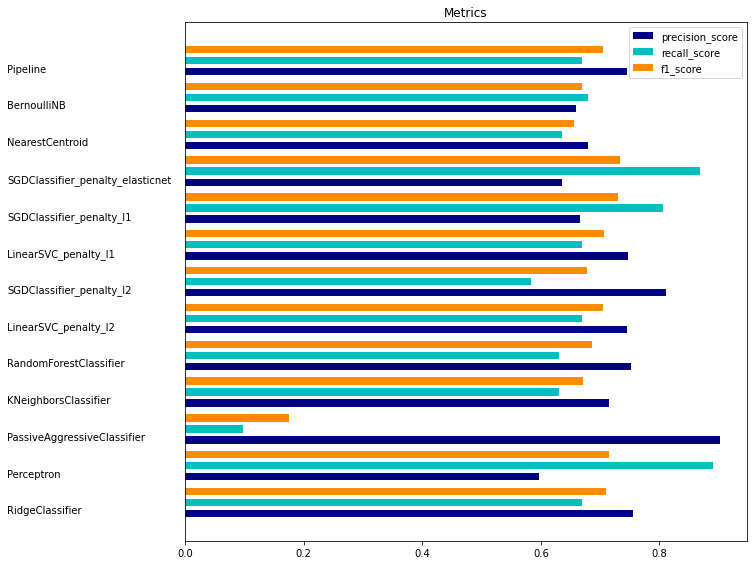

In [ ]:
indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(6)]

clf_names, precision_score, recall_score, f1_score, training_time, test_time = results
#training_time = np.array(training_time) / np.max(training_time)
#test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Metrics")
plt.barh(indices, precision_score, .2, label="precision_score", color='navy')
plt.barh(indices + .3, recall_score, .2, label="recall_score",
         color='c')
plt.barh(indices + .6, f1_score, .2, label="f1_score", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()

In [ ]:
df = pd.DataFrame()
df['Name'] = results[0]
df['Precision'] = results[1]
df['Recall'] = results[2]
df['F1_Score'] = results[3]
df['Training_time'] = results[4]
df['Test_time'] = results[5]

In [ ]:
df

,Name,Precision,Recall,F1_Score,Training_time,Test_time
0,RidgeClassifier,0.755981,0.669492,0.710112,0.222172,0.001342
1,Perceptron,0.596591,0.889831,0.714286,0.090318,0.001684
2,PassiveAggressiveClassifier,0.901961,0.097458,0.175908,0.097075,0.001438
3,KNeighborsClassifier,0.714628,0.631356,0.670416,0.198270,3.484653
4,RandomForestClassifier,0.752525,0.631356,0.686636,8.344966,0.034059
5,LinearSVC_penalty_l2,0.745283,0.669492,0.705357,0.381600,0.001328
6,SGDClassifier_penalty_l2,0.811209,0.582627,0.678175,0.260063,0.001580
7,LinearSVC_penalty_l1,0.747045,0.669492,0.706145,5.285557,0.001626
8,SGDClassifier_penalty_l1,0.666667,0.805085,0.729367,0.603451,0.001266
9,SGDClassifier_penalty_elasticnet,0.635659,0.868644,0.734109,0.540048,0.001474


In [ ]:
df.to_csv(data_directory + 'GloVe_pretrained_Twitter_results.tsv', sep='\t')